x_shaped size 888


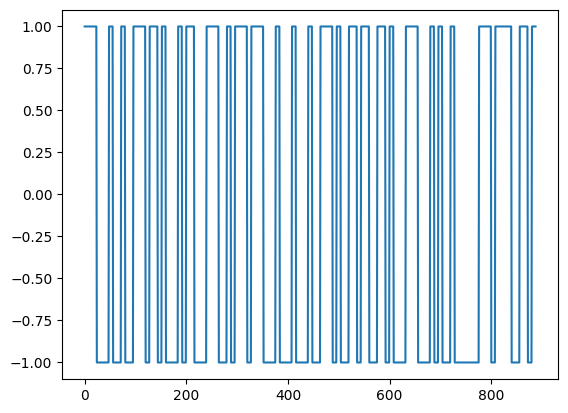

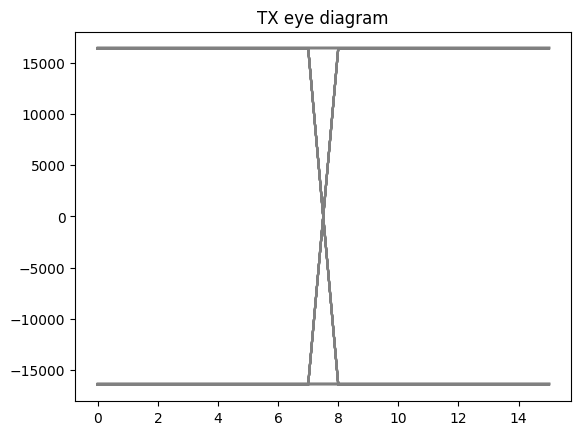

In [18]:
import numpy as np
import adi
import matplotlib.pyplot as plt
# # Stop transmitting
# Start the transmitter
# sdr.tx_destroy_buffer()

sample_rate = 1e6 # Hz
center_freq = 2e9 # Hz

sdr = adi.Pluto("ip:192.168.2.1")
sdr.sample_rate = int(sample_rate)

# Config Tx
sdr.tx_rf_bandwidth = int(sample_rate) # filter cutoff, just set it to the same as sample rate
sdr.tx_lo = int(center_freq)
sdr.tx_hardwaregain_chan0 = -10.0 # Increase to increase tx power, valid range is -90 to 0 dB

# Config RX
sdr.rx_lo = int(center_freq)
sdr.rx_rf_bandwidth = int(sample_rate)
sdr.gain_control_mode_chan0 = 'manual'
sdr.rx_hardwaregain_chan0 = 0.0 # dB, increase to increase the receive gain, but be careful not to saturate the ADC

# second Pluto 
# sdr2 = adi.Pluto("ip:192.168.3.1")
# sdr2.sample_rate = int(sample_rate)

# # Config Rx
# sdr2.rx_lo = int(center_freq)
# sdr2.rx_rf_bandwidth = int(sample_rate)
# sdr2.gain_control_mode_chan0 = 'manual'
# sdr2.rx_hardwaregain_chan0 = 50.0 # dB, increase to increase the receive gain, but be careful not to saturate the ADC

# Create transmit waveform (BPSK)
barker = [1,1,1,-1,-1,-1,1,-1,-1,1,-1]
num_symbols = 100
x = np.random.randint(0,2,num_symbols)
x_symbols = x*2 - 1 
sps = 8
sample = np.append(barker, x_symbols)
samples = np.repeat(sample, sps)



plt.figure()
plt.plot(samples)
x_shaped = samples * 2**14 #to account for sdr wanting range of [-2e14, 2e14]

num_samps = 6*len(x_shaped) # number of samples per call to rx()
sdr.rx_buffer_size = int(num_samps)


sdr.tx_cyclic_buffer = True # Enable cyclic buffers
sdr.tx(x_shaped) # start transmitting

print("x_shaped size", len(x_shaped))

plt.figure()
for k in range(len(x_shaped)):
    plt.plot(np.real(x_shaped[k*sps:(k+2)*sps]), color='gray', alpha=0.5)
plt.title("TX eye diagram")



# Clear buffer just to be safe
for i in range (0, 10):
    raw_data = sdr.rx()

h [-154.26661489-180.12165758j -150.8311321 -177.21165196j
  155.46237496+178.32961048j -153.30218044-172.47156714j
 -150.36761604-171.74277291j -151.83017262-170.45116216j
 -159.50744916-177.71430349j -155.61503689-173.76121631j
 -150.31581242-172.17768885j -160.20302875-180.45218087j
  156.95863105+173.29162743j  155.27086044+170.34071709j
  157.89334794+175.82573952j  158.20979485+165.6914627j
  154.46055851+165.79486079j -161.03760914-177.10982029j
  159.99807101+170.48934651j  160.77355815+170.51939186j
  157.97828298+164.37415279j  164.95793742+176.5187777j
  161.96456833+172.08276673j  161.20359832+169.34993324j
 -160.85092164-166.6132678j  -157.83893227-170.66889424j
  163.01947552+169.92542658j  166.90152073+169.62276491j
 -163.28021844-168.91586742j -166.19573223-169.9411033j
  164.53377139+166.89409239j -161.83389859-164.11821736j
  165.42988719+172.26419368j -164.59060977-165.28439483j
 -163.3442665 -159.83632442j  169.93101518+170.14244056j
 -164.94953055-165.33799434j  16

Move device, Press Enter to continue 


distances are [0.09609360870873777]
delta d is []
average delta d is nan


Text(0.5, 1.0, 'hest')

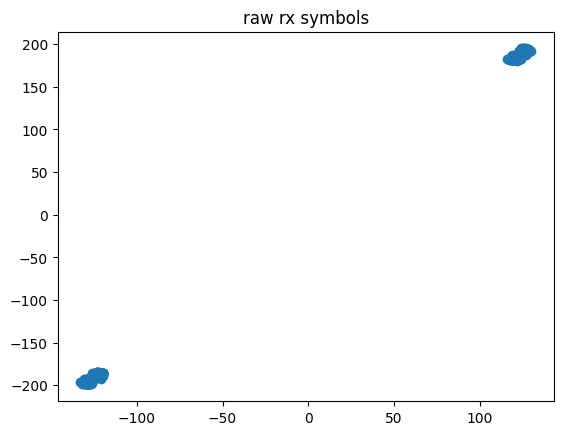

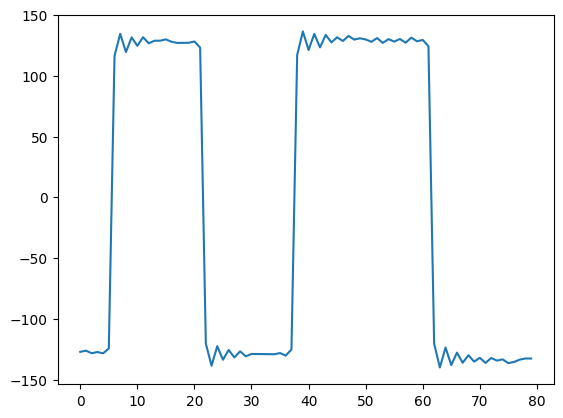

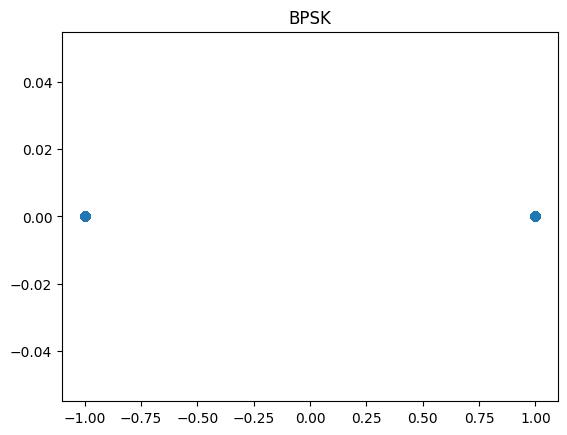

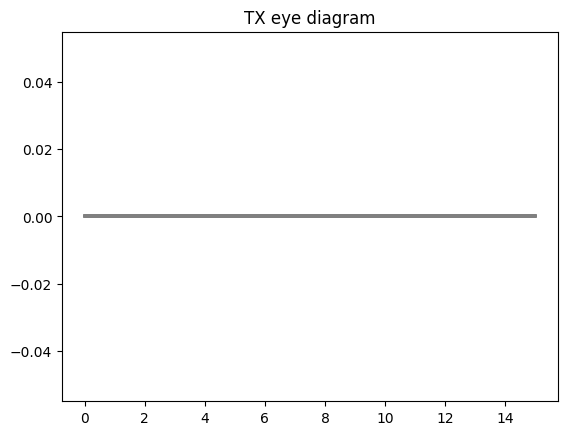

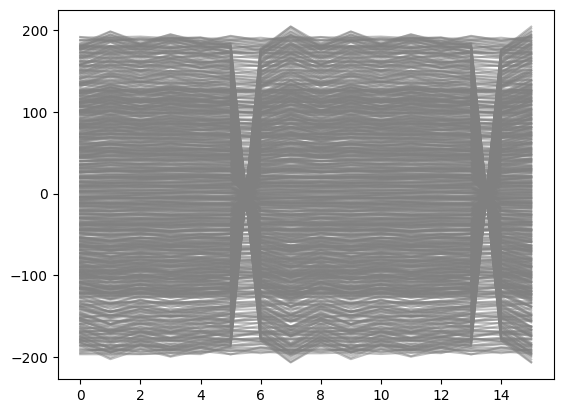

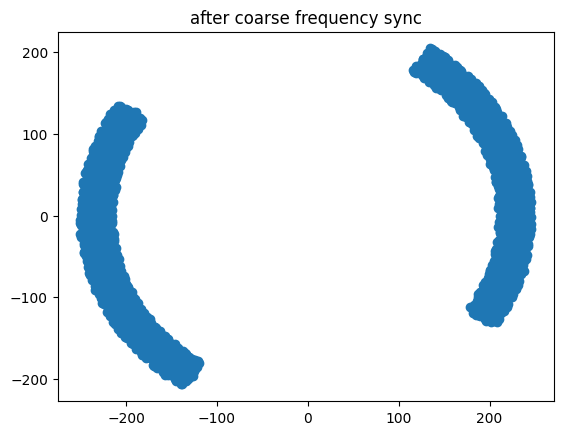

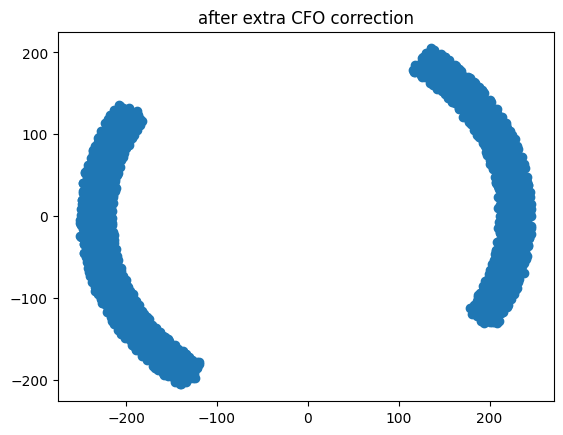

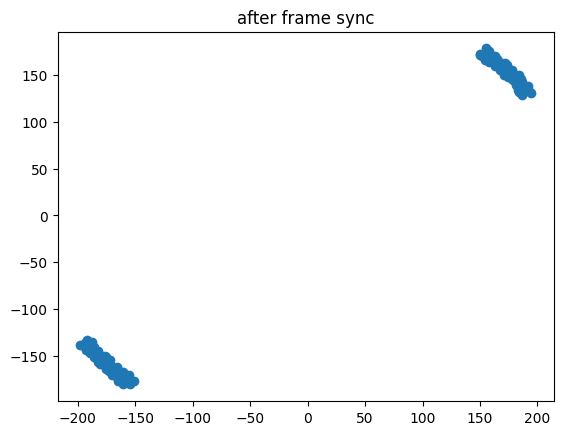

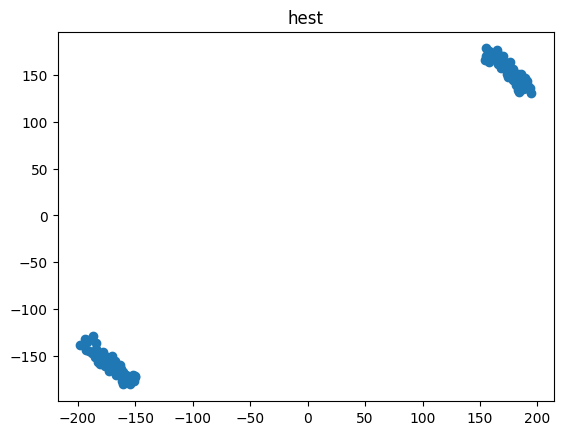

In [16]:

movements = 1 #total amount of time you move
iterations = 1 #average each movement
avg_distances = []

for i in range(movements): 
    distances = []
    for j in range(iterations):
        # Receive samples
        rx_samples = sdr.rx()

        plt.figure()
        plt.scatter(np.real(rx_samples[::sps]), np.imag(rx_samples[::sps]))
        plt.title("raw rx symbols")
        # print("max sample", np.max(rx_samples))


        # Calculate power spectral density (frequency domain version of signal)
        psd = np.abs(np.fft.fftshift(np.fft.fft(rx_samples)))**2
        psd_dB = 10*np.log10(psd)
        f = np.linspace(sample_rate/-2, sample_rate/2, len(psd))
        
        # coarse frequency 
        rx_samples_squared = rx_samples**2
        psd = np.fft.fftshift(np.abs(np.fft.fft(rx_samples_squared)))
        f = np.linspace(-sample_rate/2.0, sample_rate/2.0, len(psd))
        # plt.plot(f, psd)
        # plt.show()
        
        max_freq = f[np.argmax(psd)]
        # print("max frequency", max_freq)
        Ts = 1/sample_rate # calc sample period
        t = np.arange(0, Ts*num_samps, Ts) # create time vector, i just set to num_samps so it's able to fetch? rn num_samps set to one capture
        rx_samples = rx_samples * np.exp(-1j*2*np.pi*max_freq*t/2.0)


        # #costas loop -> before frame sync
        # N = len(rx_samples)
        # phase = 0
        # freq = 0
        # # These next two params is what to adjust, to make the feedback loop faster or slower (which impacts stability)
        # alpha = 0.132
        # beta = 0.00932
        # rx_out = np.zeros(N, dtype=complex)
        # freq_log = []
        # for i in range(N):
        #     rx_out[i] = rx_samples[i] * np.exp(-1j*phase) # adjust the input sample by the inverse of the estimated phase offset
        #     error = np.real(rx_out[i]) * np.imag(rx_out[i]) # This is the error formula for 2nd order Costas Loop (e.g. for BPSK)
        
        #     # Advance the loop (recalc phase and freq offset)
        #     freq += (beta * error)
        #     freq_log.append(freq * sample_rate / (2*np.pi)) # convert from angular velocity to Hz for logging
        #     phase += freq + (alpha * error)
        
        #     # Optional: Adjust phase so its always between 0 and 2pi, recall that phase wraps around every 2pi
        #     while phase >= 2*np.pi:
        #         phase -= 2*np.pi
        #     while phase < 0:
        #         phase += 2*np.pi
                
        
        
        # # no more CFO correction
        # rx_extra = rx_samples

        # # connect Costas with more CFO correction
        # rx_samples = rx_out
        
        # more CFO correction > multiply by conjugate of angle difference bewteen two constellation points
        rx_extra = []
        angles = []
        for i in range(len(rx_samples)-1):
            angles.append(np.angle(rx_samples[i+1])-np.angle(rx_samples[i]))
        for i in range(len(rx_samples)-1):
            rx_extra.append(rx_samples[i]*np.exp(-1j*angles[i]))

        

        # frame sync 
        def max_in_arr(arr, n):
            # Initialize maximum element
            max_elem = arr[0]
            max_i = 0
            # Traverse array elements from second
            # and compare every element with
            # current max
            for i in range(1, n):
                if arr[i] > max_elem:
                    max_elem = arr[i]
                    max_i = i 
            return max_i
        
        barker_sample = np.repeat(barker, sps)
        arr = np.correlate(barker_sample, rx_extra[0:int(len(rx_samples)/2)]) #just frame sync half of received samples, not the most accurate but cuts down runtime
        k = max_in_arr(arr, len(arr))
    
        #we shift now 
        rx_shifted = rx_extra[k:k+len(samples)]
        
        if len(rx_shifted) < len(samples):
            raise Exception("rx shifted too much, not enough data to capture. increase num samps")



        
        
        # channel est
        rx_shifted = rx_shifted[0:len(x_shaped)]
        rx_shifted = rx_shifted[::sps]
        hest = rx_shifted / sample

        print("h", hest[0:100])
        print("hest angle", np.angle(hest[0:100]))
        
        
        # calculate the frequencies
        a = - np.angle(hest) / (2*np.pi*center_freq)
        tau = a % (1/center_freq)
        d = tau*3e8
        print("d", d)
        
        distances.append(np.average(d))

    avg_distances.append(np.average(distances))
    input("Move device, Press Enter to continue")
    
print("distances are", distances)

delta_d = []
for i in range(len(avg_distances)-1):
    delta_d.append(avg_distances[i+1]-avg_distances[i])

print("delta d is", delta_d)
print("average delta d is", np.average(delta_d))


plt.figure()
plt.plot(np.real(rx_samples[0:10*sps]))

#original 
plt.figure()
plt.scatter(np.real(samples), np.imag(samples))
plt.title("BPSK")


plt.figure()
for k in range(len(rx_samples)):
    plt.plot(np.imag(rx_samples[k*sps:(k+2)*sps]), color='gray', alpha=0.5)
        
#after coarse frequency
plt.figure()
plt.scatter(np.real(rx_samples), np.imag(rx_samples))
plt.title("after coarse frequency sync")

# #after costas loop
# plt.figure()
# plt.scatter(np.real(rx_out), np.imag(rx_out))
# plt.title("after costas loop")
# # plt.ylim(-1,1)

#after extra 
plt.figure()
plt.scatter(np.real(rx_extra), np.imag(rx_extra))
plt.title("after extra CFO correction")
# plt.ylim(-1,1)

#after FRAME SYNC
plt.figure()
plt.scatter(np.real(rx_shifted), np.imag(rx_shifted))
plt.title("after frame sync")
# plt.ylim(-1,1)

#hest
plt.figure()
plt.scatter(np.real(hest), np.imag(hest))
plt.title("hest")
# plt.ylim(-1,1)


In [3]:
# quick channel correction
rx_corr = rx_shifted / hest
rx_corr = (rx_corr + 1) / 2
rx_data = rx_corr[len(barker):]
# print(rx_data)
ber = np.sum(abs(rx_data-x))/len(x)
print("ber= ", ber)

ber=  2.742220413024383e-18


In [4]:
# #CHANNEL ESTIMATION WITH SAMPLES
# L = len(sample) #number of channel coefficients we want 
# N = len(barker) #training sequence length


# #set up training sequence with samples (hs, Ls, Ns,barker) (A)
# #set up training sequence matrix (A)
# Ls = L*sps #sampled amount of L
# Ns = N*sps #sampled amount of N 

# hs = np.zeros(Ls, dtype=complex)

# #generate random h 
# for i in range(len(hs)):
#     h[i] = np.random.uniform(-1, 1) + 1.j * np.random.uniform(-1, 1)

# rows, cols = (Ns-Ls+1, Ls) 


# #create matrix A with training sequence
# As = [[0 for i in range(cols)] for k in range(rows)]

# for k in range(rows):
#     for i in range(cols):
#         As[k][i] = barker[Ls-i-1+k]

        
# #create y = h convolve b 
# ys = np.convolve(hs,barker)
# # print(len(y))

# #create matrix y 
# rows = Ns-Ls+1
# y_mat = [0 for i in range(rows)]
# for i in range(rows):
#     y_mat[i] = ys[Ls-1+i]

    
# #least square estimator
# h_est, residual, rank, s = np.linalg.lstsq(As, y_mat, rcond=None) # this gives estimated h with samples

# #take every first value of each sps in the array
# h_est = h_est[::sps]
# print("estimated h using samples is: ", h_est)